INICIANDO CARGA DE DATOS CON RTIoTClassifier...
Configurado para usar 4 trabajos en paralelo
Cargando dataset RT-IoT2022...
Error cargando datos reales: [Errno 2] No such file or directory: 'train.csv'
Usando datos de ejemplo para demostración...

EJECUTANDO ANÁLISIS EXPLORATORIO COMPLETO
ANÁLISIS EXPLORATORIO COMPLETO - RT-IoT2022

1. GENERANDO DISTRIBUCIÓN DE CLASES...


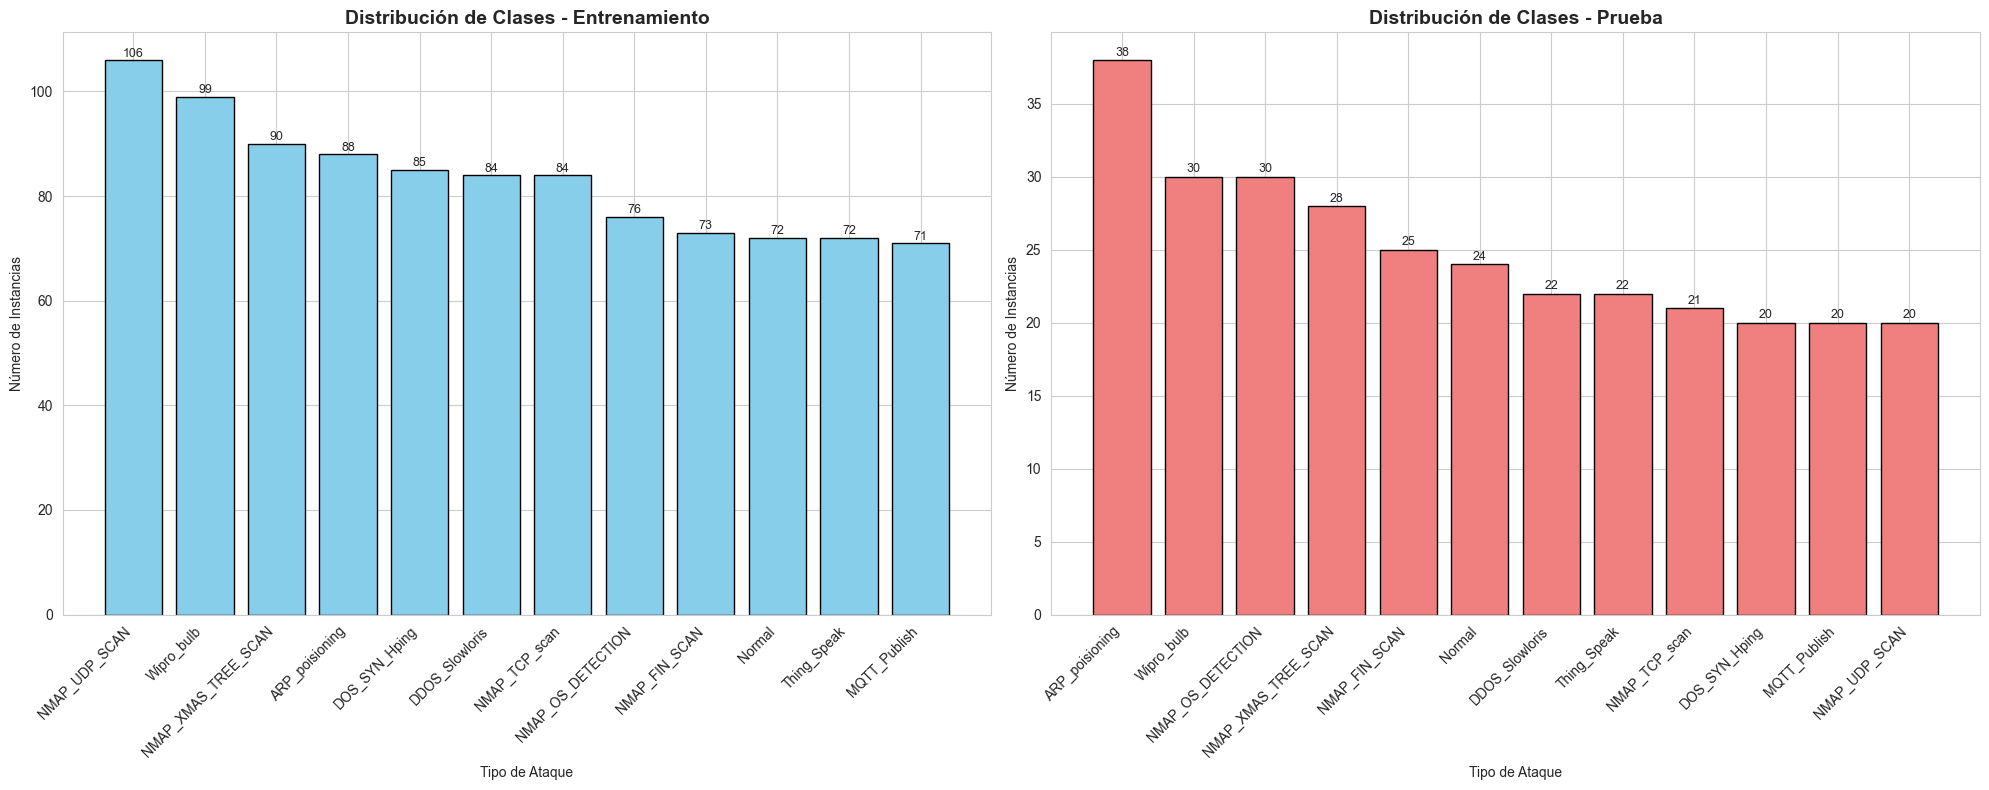


2. GENERANDO HISTOGRAMAS DE CARACTERÍSTICAS...


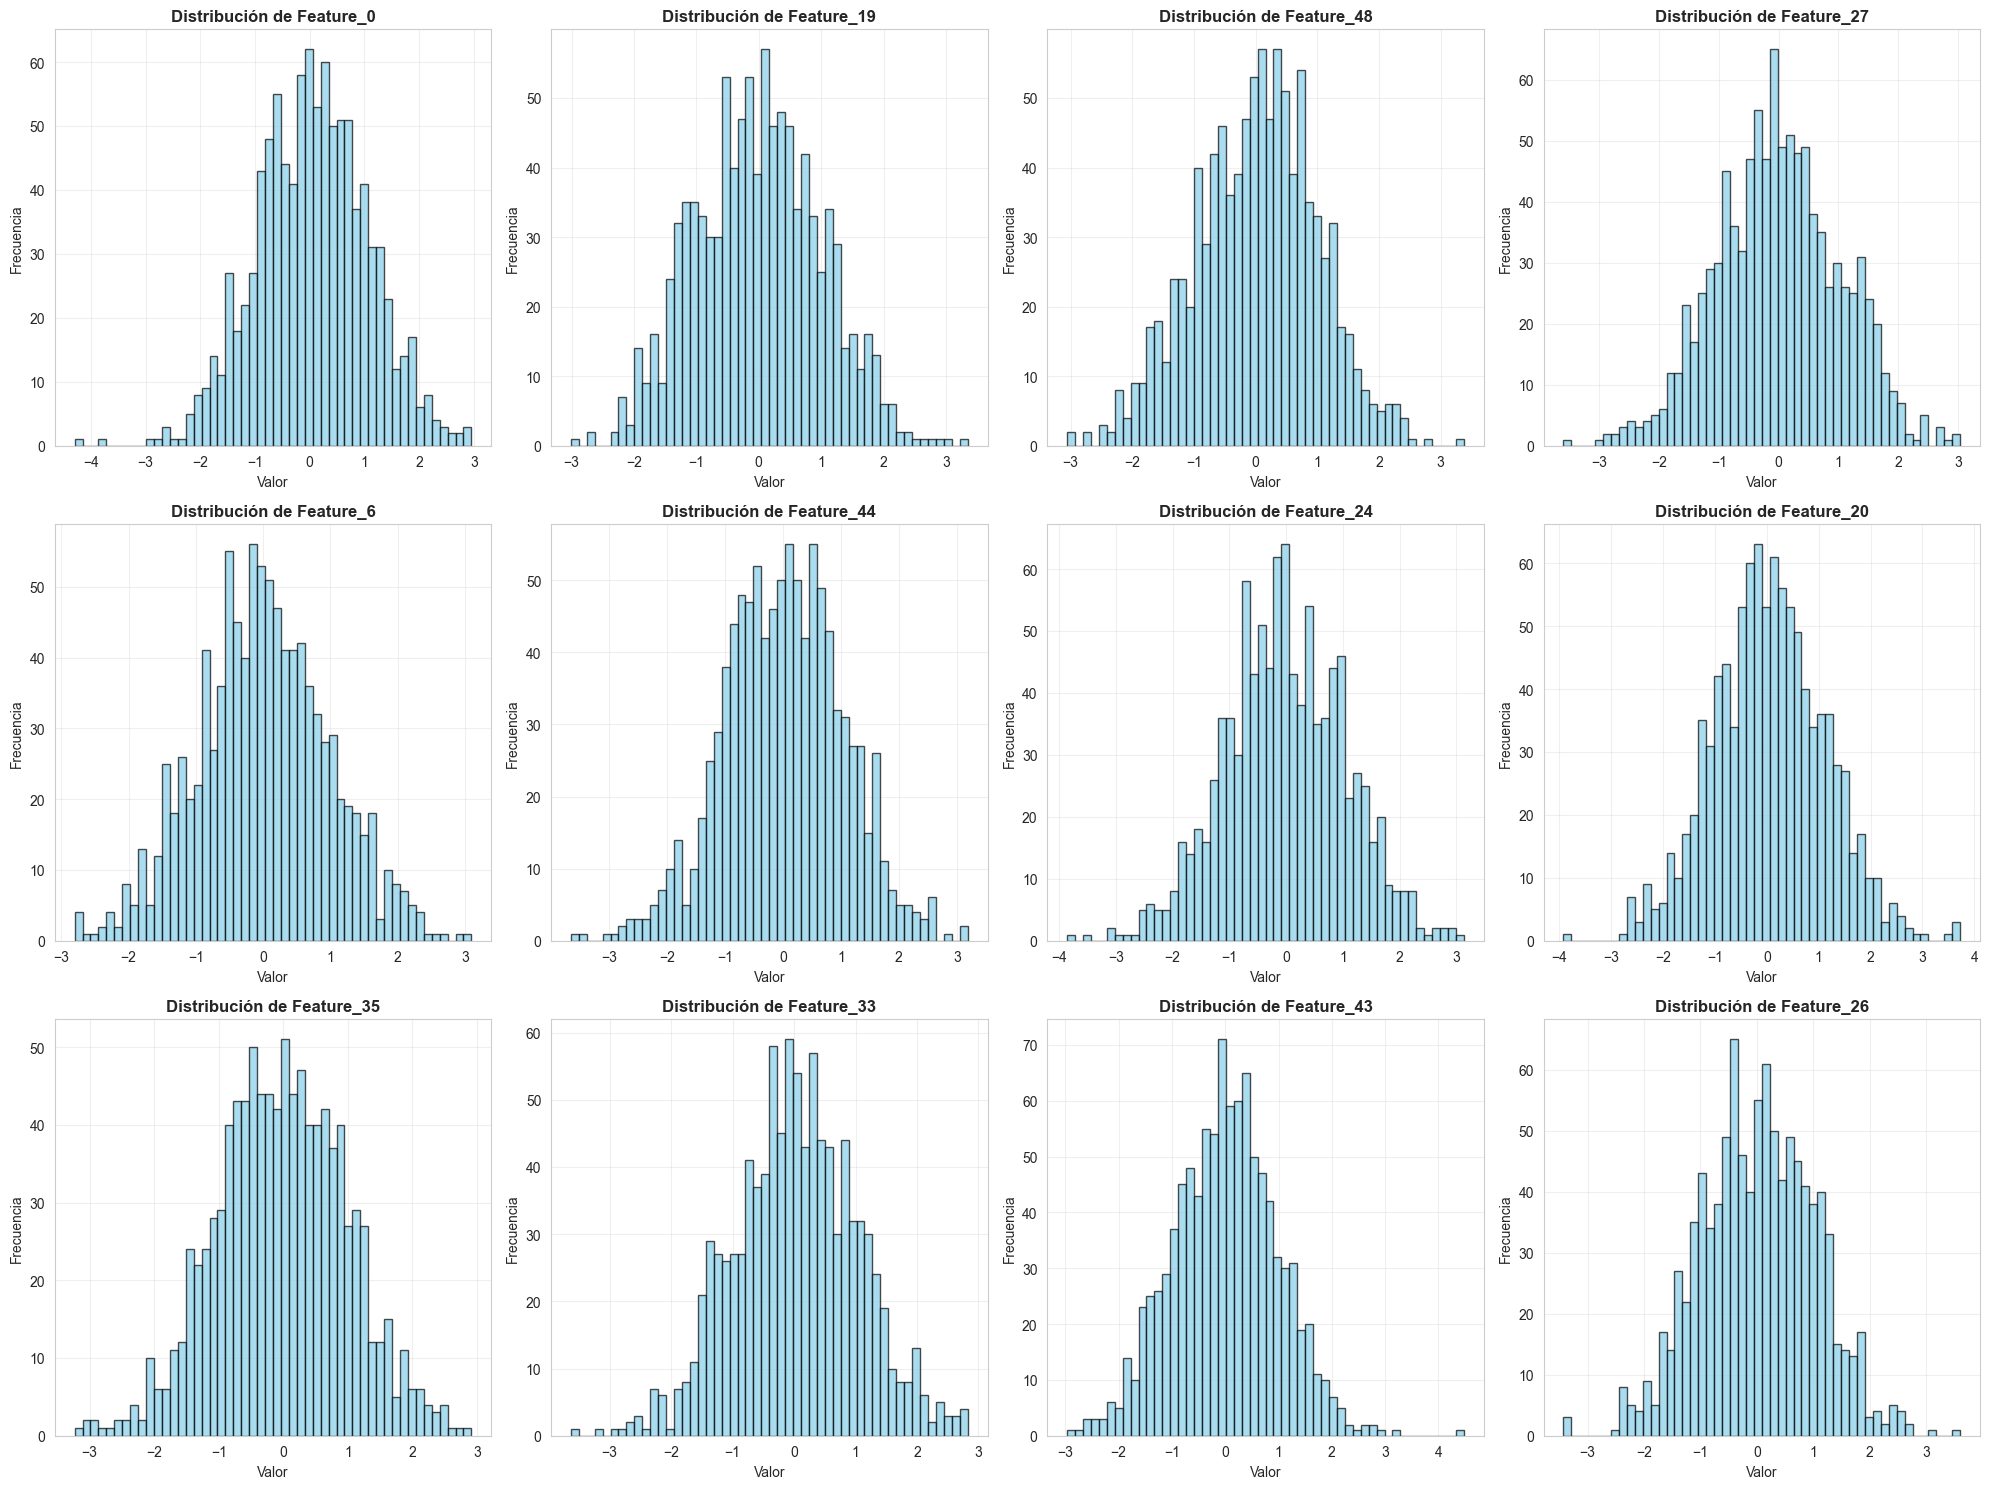


3. GENERANDO BOXPLOTS POR CLASE...


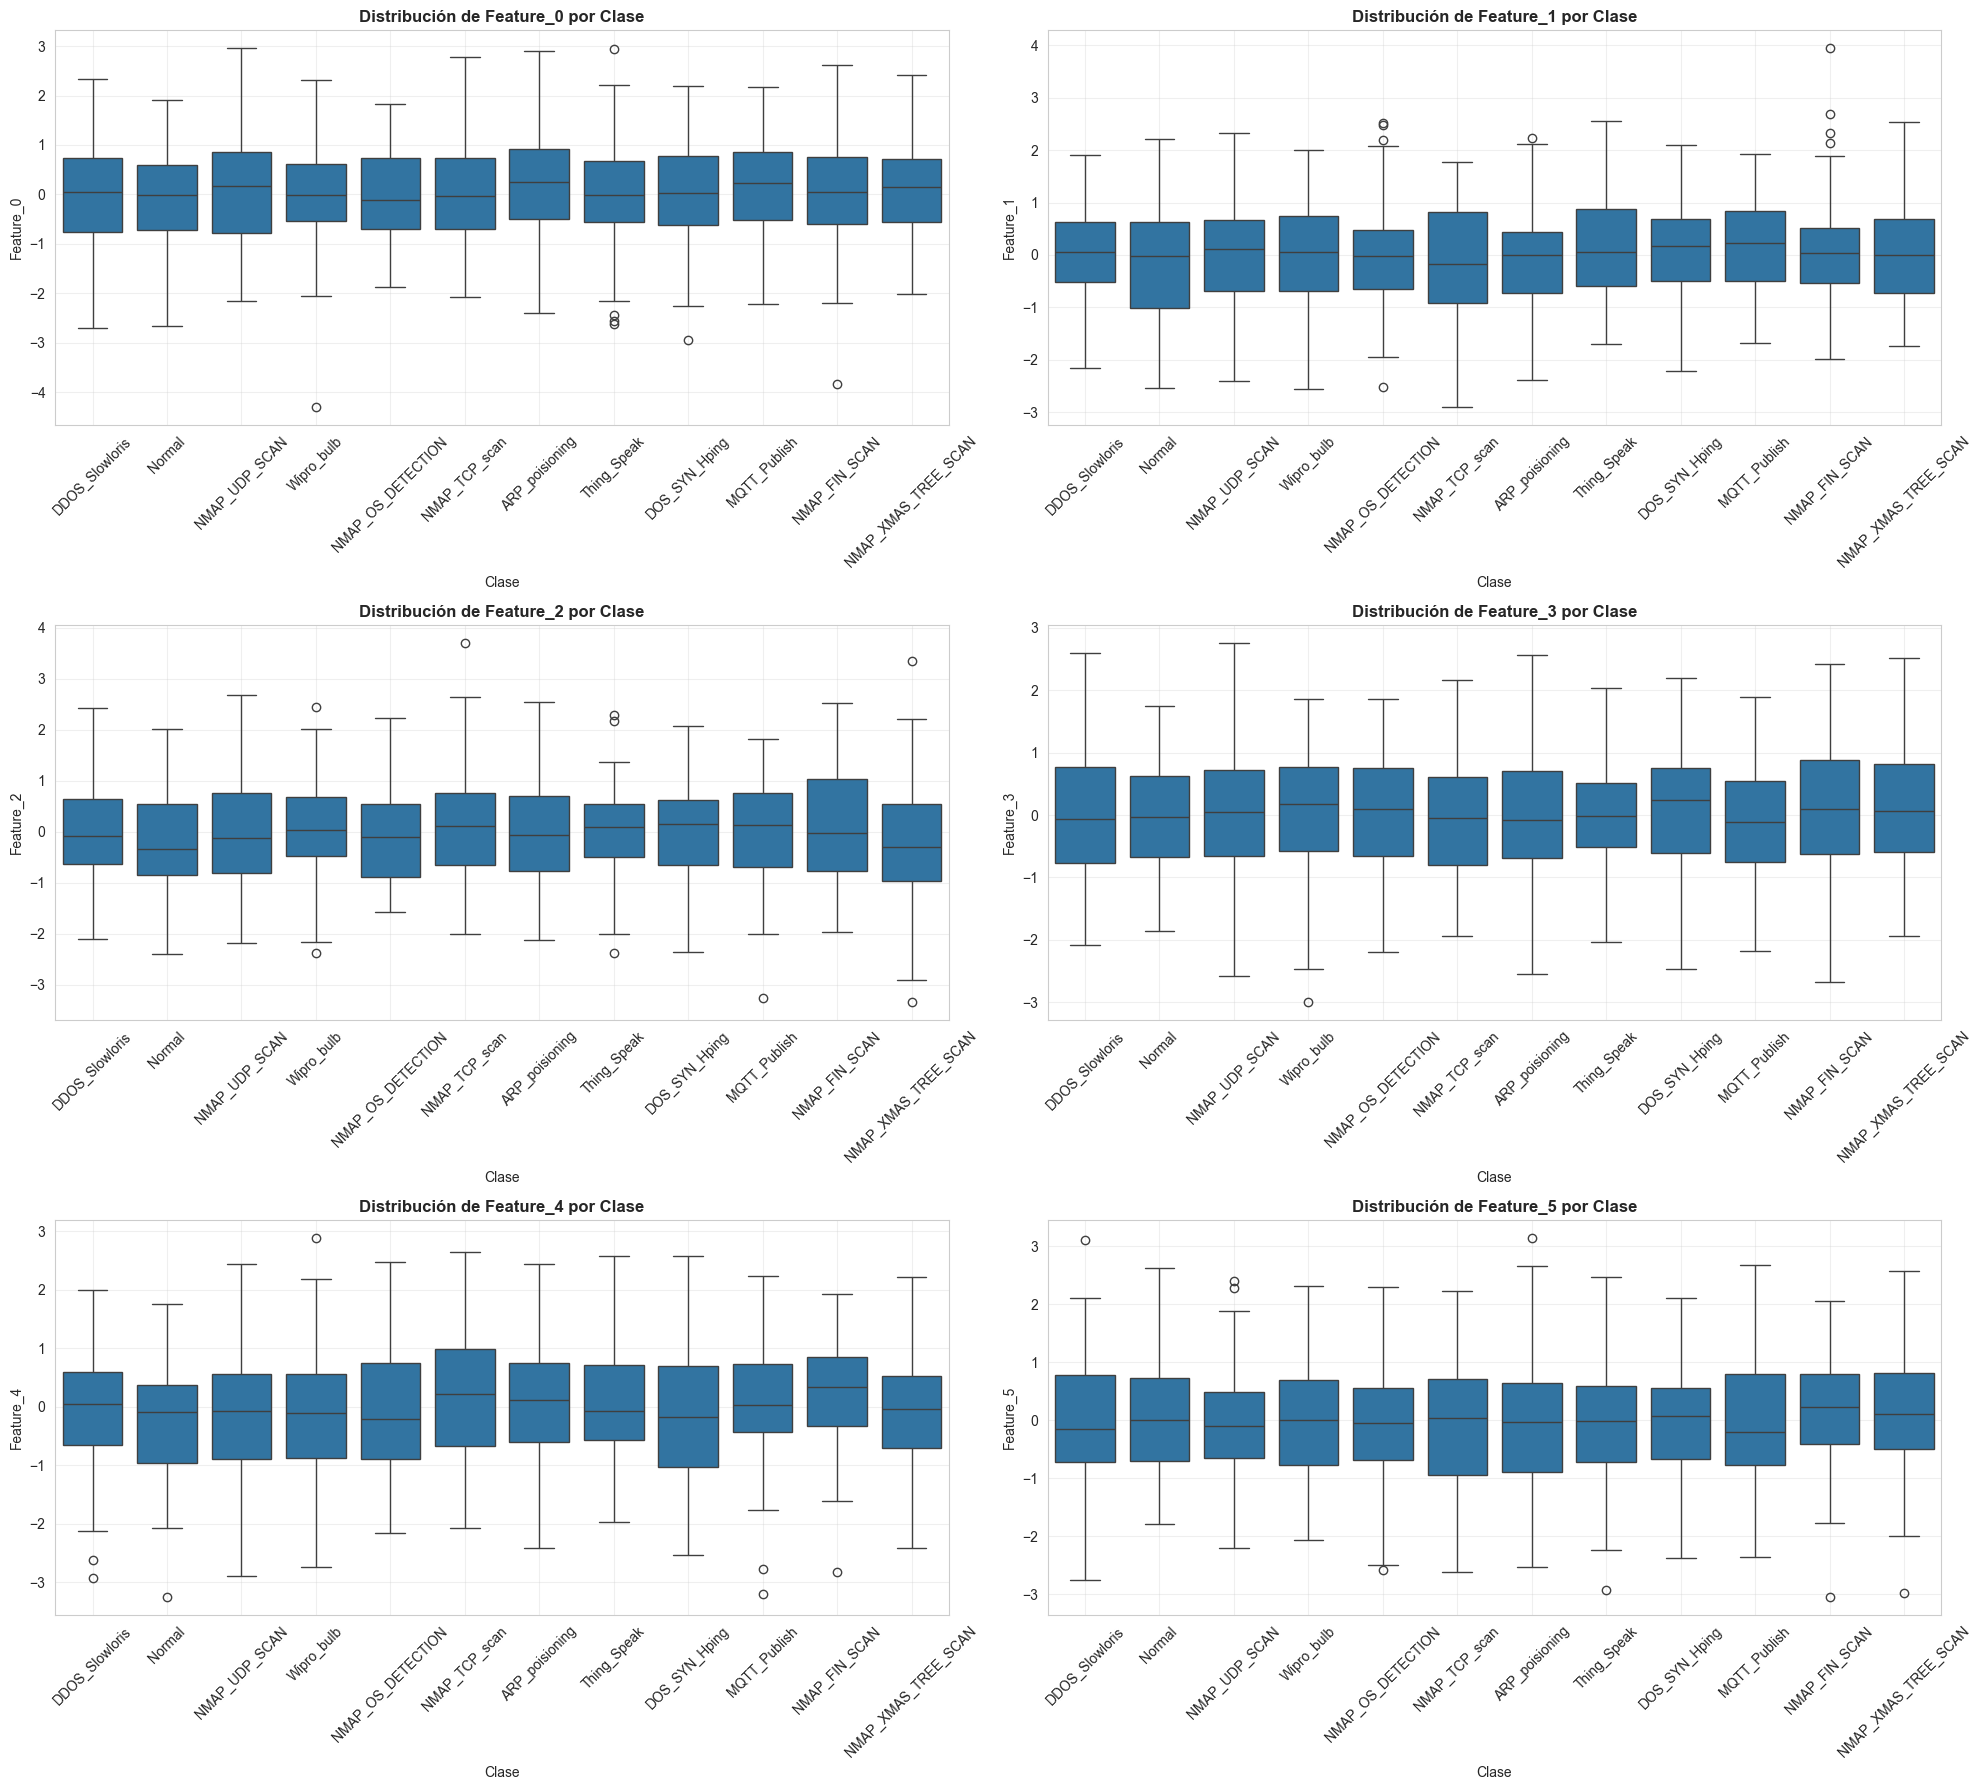


4. GENERANDO MATRIZ DE CORRELACIÓN...


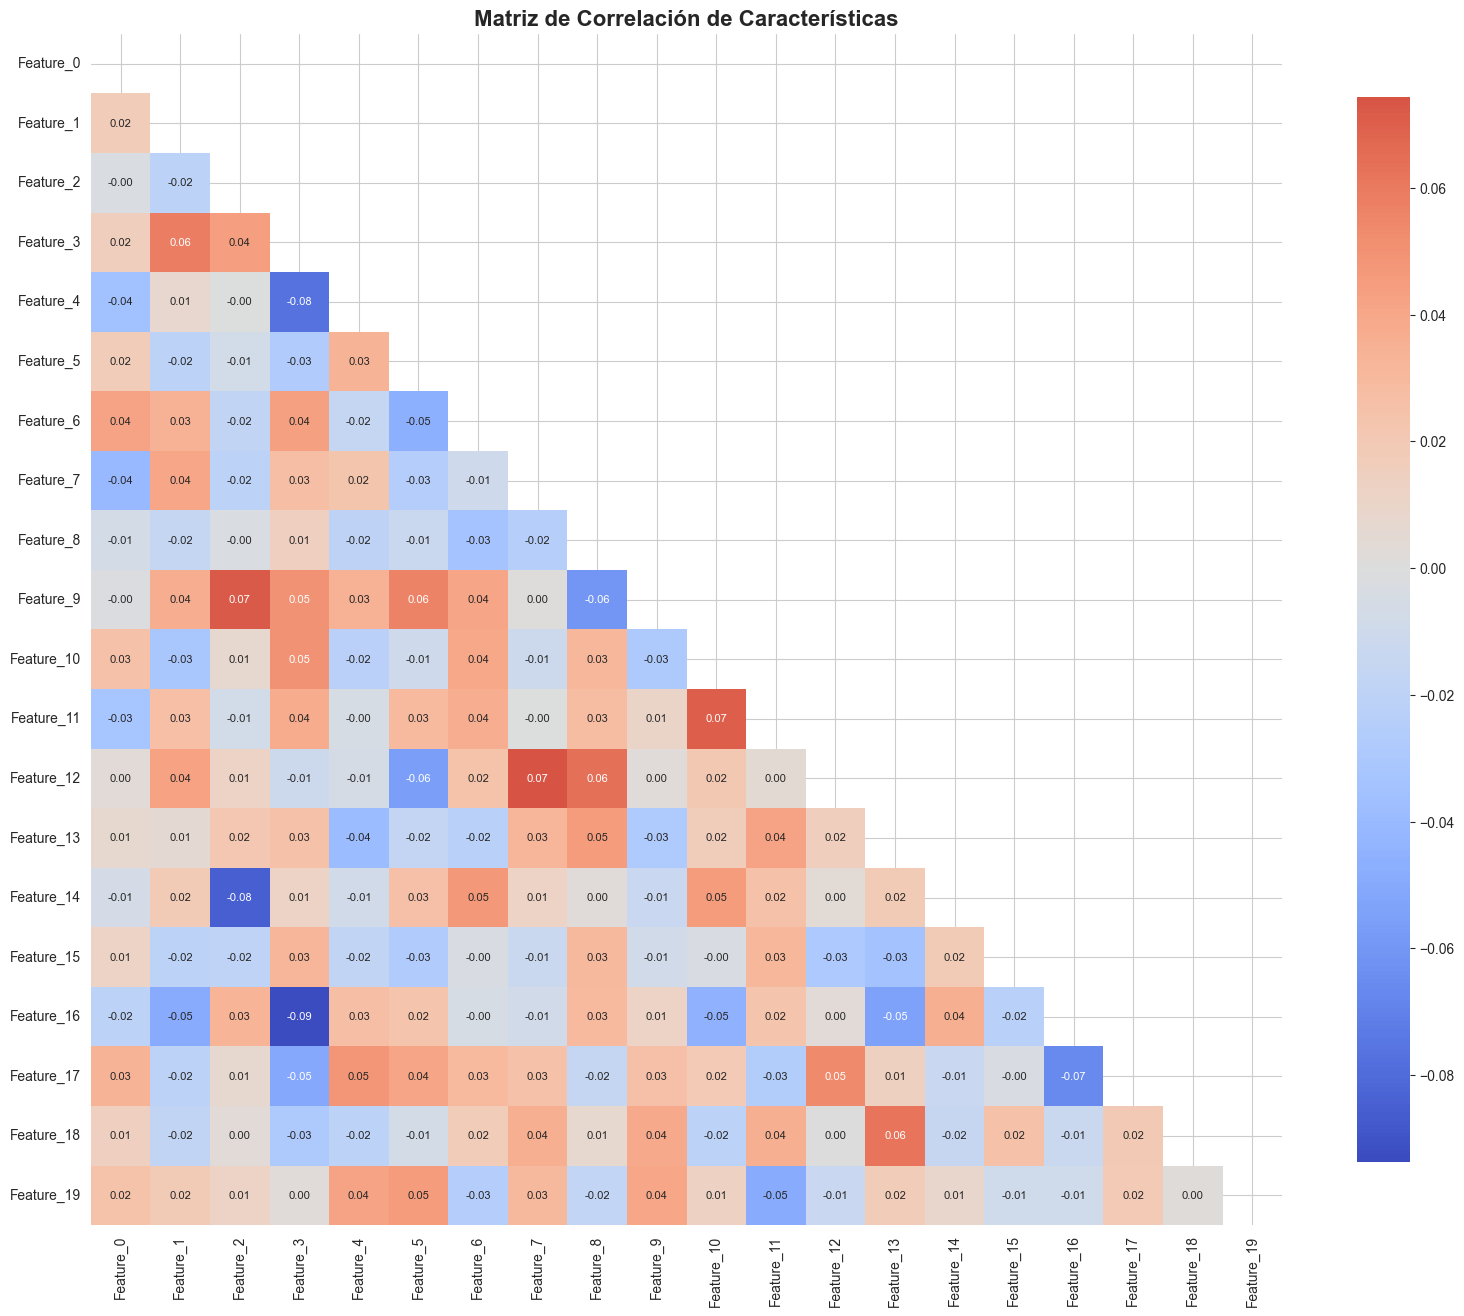


No se encontraron correlaciones altas (>0.8)

5. GENERANDO ESTADÍSTICAS DESCRIPTIVAS...
ESTADÍSTICAS DESCRIPTIVAS - DATASET RT-IoT2022

1. ESTADÍSTICAS GENERALES:
   - Total de instancias entrenamiento: 1,000
   - Total de instancias prueba: 300
   - Total de características: 50
   - Número de clases: 12

2. DISTRIBUCIÓN POR CLASE:

   ENTRENAMIENTO:
     - NMAP_UDP_SCAN: 106 instancias (10.60%)
     - Wipro_bulb: 99 instancias (9.90%)
     - NMAP_XMAS_TREE_SCAN: 90 instancias (9.00%)
     - ARP_poisioning: 88 instancias (8.80%)
     - DOS_SYN_Hping: 85 instancias (8.50%)
     - DDOS_Slowloris: 84 instancias (8.40%)
     - NMAP_TCP_scan: 84 instancias (8.40%)
     - NMAP_OS_DETECTION: 76 instancias (7.60%)
     - NMAP_FIN_SCAN: 73 instancias (7.30%)
     - Normal: 72 instancias (7.20%)
     - Thing_Speak: 72 instancias (7.20%)
     - MQTT_Publish: 71 instancias (7.10%)

   PRUEBA:
     - ARP_poisioning: 38 instancias (12.67%)
     - Wipro_bulb: 30 instancias (10.00%)
     - NMAP_OS_DE

In [4]:
# ANÁLISIS EXPLORATORIO COMPLETO - RT-IoT2022
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from joblib import Parallel, delayed

# Configuración para mostrar gráficos
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")

# =============================================================================
# DEFINICIÓN DE LA CLASE RTIoTClassifier
# =============================================================================

class RTIoTClassifier:
    def __init__(self, n_jobs=-1, use_feature_selection=True):
        self.n_jobs = n_jobs if n_jobs != -1 else self._get_optimal_jobs()
        self.use_feature_selection = use_feature_selection
        print(f"Configurado para usar {self.n_jobs} trabajos en paralelo")

        # Modelos
        self.models = {
            "LogisticRegression": LogisticRegression(
                max_iter=500, random_state=42, n_jobs=self.n_jobs
            ),
            "RandomForest": RandomForestClassifier(
                n_estimators=50, random_state=42, n_jobs=self.n_jobs
            ),
            "SVM_Linear_Optimized": LinearSVC(
                random_state=42, max_iter=1000, dual=False
            ),
            "DecisionTree": DecisionTreeClassifier(random_state=42, max_depth=20),
            "KNN": KNeighborsClassifier(n_neighbors=5, n_jobs=self.n_jobs),
        }
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.feature_selector = None
        self.results = {}

    def _get_optimal_jobs(self):
        """Determinar el número óptimo de trabajos paralelos"""
        import os
        return min(4, os.cpu_count() - 1 if os.cpu_count() > 1 else 1)

    def load_and_preprocess_data(self, train_path, test_path, max_features=100):
        """Cargar y preprocesar datos con selección de características"""
        print("Cargando dataset RT-IoT2022...")

        # Cargar datos
        train_df = pd.read_csv(train_path, low_memory=False)
        test_df = pd.read_csv(test_path, low_memory=False)

        print(f"Dimensiones Train: {train_df.shape}")
        print(f"Dimensiones Test: {test_df.shape}")

        # Optimizar uso de memoria
        train_df = self._optimize_dataframe(train_df)
        test_df = self._optimize_dataframe(test_df)

        # Separar características y target
        X_train = train_df.drop("Attack_type", axis=1)
        y_train = train_df["Attack_type"]

        if "Attack_type" in test_df.columns:
            X_test = test_df.drop("Attack_type", axis=1)
            y_test = test_df["Attack_type"]
        else:
            X_test = test_df
            y_test = None

        # Preprocesamiento con selección de características
        X_train_processed, X_test_processed, y_train_encoded, y_test_encoded = (
            self._preprocess_with_feature_selection(
                X_train, X_test, y_train, y_test, max_features
            )
        )

        return (
            X_train_processed,
            X_test_processed,
            y_train_encoded,
            y_test_encoded,
            y_test,
        )

    def _optimize_dataframe(self, df):
        """Optimizar tipos de datos para reducir uso de memoria"""
        numeric_columns = df.select_dtypes(include=[np.number]).columns
        for col in numeric_columns:
            if df[col].dtype == "float64":
                df[col] = df[col].astype("float32")
            elif df[col].dtype == "int64":
                col_min = df[col].min()
                col_max = df[col].max()
                if col_min >= 0:
                    if col_max < 256:
                        df[col] = df[col].astype("uint8")
                    elif col_max < 65536:
                        df[col] = df[col].astype("uint16")
                    else:
                        df[col] = df[col].astype("uint32")
                else:
                    if col_min > -128 and col_max < 127:
                        df[col] = df[col].astype("int8")
                    elif col_min > -32768 and col_max < 32767:
                        df[col] = df[col].astype("int16")
                    else:
                        df[col] = df[col].astype("int32")
        return df

    def _preprocess_with_feature_selection(
        self, X_train, X_test, y_train, y_test, max_features
    ):
        """Preprocesamiento con selección de características"""
        print("Iniciando preprocesamiento con selección de características...")

        numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
        categorical_features = X_train.select_dtypes(
            include=["object", "bool"]
        ).columns.tolist()

        print(f"Características numéricas: {len(numeric_features)}")
        print(f"Características categóricas: {len(categorical_features)}")

        # Codificar características categóricas
        for col in categorical_features:
            if col in X_train.columns:
                le = LabelEncoder()
                combined = pd.concat([X_train[col], X_test[col]], axis=0)
                le.fit(combined.astype(str))
                X_train[col] = le.transform(X_train[col].astype(str))
                X_test[col] = le.transform(X_test[col].astype(str))

        # Escalar características numéricas
        X_train_scaled = X_train.copy()
        X_test_scaled = X_test.copy()

        if numeric_features:
            X_train_scaled[numeric_features] = self.scaler.fit_transform(
                X_train[numeric_features]
            )
            X_test_scaled[numeric_features] = self.scaler.transform(
                X_test[numeric_features]
            )

        # Manejar valores NaN
        X_train_scaled = X_train_scaled.fillna(0)
        X_test_scaled = X_test_scaled.fillna(0)

        # Selección de características para acelerar modelos
        if self.use_feature_selection and X_train_scaled.shape[1] > max_features:
            print(
                f"Aplicando selección de características: {X_train_scaled.shape[1]} -> {max_features}"
            )
            self.feature_selector = SelectKBest(score_func=f_classif, k=max_features)
            X_train_scaled = self.feature_selector.fit_transform(
                X_train_scaled, y_train
            )
            X_test_scaled = self.feature_selector.transform(X_test_scaled)
            print(f"Dimensiones después de selección: {X_train_scaled.shape}")

        # Codificar target
        y_train_encoded = self.label_encoder.fit_transform(y_train)
        y_test_encoded = (
            self.label_encoder.transform(y_test) if y_test is not None else None
        )

        print("Preprocesamiento completado")
        return X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded

# =============================================================================
# FUNCIÓN DE ANÁLISIS EXPLORATORIO
# =============================================================================

def complete_eda_analysis(X_train, X_test, y_train, y_test, label_encoder, dataset_name="RT-IoT2022"):
    """
    Análisis exploratorio completo para el dataset RT-IoT2022
    """
    
    print("=" * 80)
    print(f"ANÁLISIS EXPLORATORIO COMPLETO - {dataset_name}")
    print("=" * 80)
    
    # Convertir a DataFrames si son arrays numpy
    if not isinstance(X_train, pd.DataFrame):
        if hasattr(X_train, 'shape'):
            feature_names = [f'Feature_{i}' for i in range(X_train.shape[1])]
            X_train_df = pd.DataFrame(X_train, columns=feature_names)
            X_test_df = pd.DataFrame(X_test, columns=feature_names)
        else:
            print("Error: X_train no es un DataFrame ni un array numpy válido")
            return
    else:
        X_train_df = X_train.copy()
        X_test_df = X_test.copy()
        feature_names = X_train.columns.tolist()
    
    # Convertir labels a nombres originales
    y_train_names = label_encoder.inverse_transform(y_train)
    y_test_names = label_encoder.inverse_transform(y_test)
    
    # =========================================================================
    # 1. DISTRIBUCIÓN DE CLASES
    # =========================================================================
    print("\n1. GENERANDO DISTRIBUCIÓN DE CLASES...")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Train distribution
    train_counts = pd.Series(y_train_names).value_counts()
    bars1 = ax1.bar(range(len(train_counts)), train_counts.values, color='skyblue', edgecolor='black')
    ax1.set_title('Distribución de Clases - Entrenamiento', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Tipo de Ataque')
    ax1.set_ylabel('Número de Instancias')
    ax1.set_xticks(range(len(train_counts)))
    ax1.set_xticklabels(train_counts.index, rotation=45, ha='right')
    
    # Añadir valores en las barras
    for bar, count in zip(bars1, train_counts.values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{count:,}', ha='center', va='bottom', fontsize=9)
    
    # Test distribution
    test_counts = pd.Series(y_test_names).value_counts()
    bars2 = ax2.bar(range(len(test_counts)), test_counts.values, color='lightcoral', edgecolor='black')
    ax2.set_title('Distribución de Clases - Prueba', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Tipo de Ataque')
    ax2.set_ylabel('Número de Instancias')
    ax2.set_xticks(range(len(test_counts)))
    ax2.set_xticklabels(test_counts.index, rotation=45, ha='right')
    
    # Añadir valores en las barras
    for bar, count in zip(bars2, test_counts.values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{count:,}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # =========================================================================
    # 2. HISTOGRAMAS DE CARACTERÍSTICAS NUMÉRICAS
    # =========================================================================
    print("\n2. GENERANDO HISTOGRAMAS DE CARACTERÍSTICAS...")
    
    # Seleccionar solo características numéricas
    numeric_features = X_train_df.select_dtypes(include=[np.number]).columns.tolist()
    
    if len(numeric_features) > 12:
        selected_features = np.random.choice(numeric_features, 12, replace=False)
    else:
        selected_features = numeric_features[:min(12, len(numeric_features))]
    
    n_cols = 4
    n_rows = (len(selected_features) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes]
    
    for i, feature in enumerate(selected_features):
        if feature in X_train_df.columns:
            axes[i].hist(X_train_df[feature].values, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
            axes[i].set_title(f'Distribución de {feature}', fontsize=12, fontweight='bold')
            axes[i].set_xlabel('Valor')
            axes[i].set_ylabel('Frecuencia')
            axes[i].grid(True, alpha=0.3)
    
    # Ocultar ejes vacíos
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # =========================================================================
    # 3. BOXPLOTS POR CLASE
    # =========================================================================
    print("\n3. GENERANDO BOXPLOTS POR CLASE...")
    
    # Seleccionar 6 características importantes para boxplots
    if len(numeric_features) >= 6:
        important_features = numeric_features[:6]
    else:
        important_features = numeric_features
    
    n_cols = 2
    n_rows = (len(important_features) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()
    
    # Crear DataFrame temporal para boxplots
    temp_df = X_train_df[important_features].copy()
    temp_df['class'] = y_train_names
    
    for i, feature in enumerate(important_features):
        if feature in X_train_df.columns:
            # Boxplot
            sns.boxplot(data=temp_df, x='class', y=feature, ax=axes[i])
            axes[i].set_title(f'Distribución de {feature} por Clase', fontsize=12, fontweight='bold')
            axes[i].set_xlabel('Clase')
            axes[i].set_ylabel(feature)
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].grid(True, alpha=0.3)
    
    # Ocultar ejes vacíos
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # =========================================================================
    # 4. MATRIZ DE CORRELACIÓN
    # =========================================================================
    print("\n4. GENERANDO MATRIZ DE CORRELACIÓN...")
    
    # Seleccionar solo características numéricas y limitar a 20 para mejor visualización
    if len(numeric_features) > 20:
        selected_features = numeric_features[:20]
    else:
        selected_features = numeric_features
    
    # Calcular matriz de correlación
    corr_matrix = X_train_df[selected_features].corr()
    
    plt.figure(figsize=(16, 14))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Máscara para el triángulo superior
    heatmap = sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
                         center=0, square=True, cbar_kws={"shrink": .8}, annot_kws={"size": 8})
    plt.title('Matriz de Correlación de Características', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Identificar correlaciones altas
    high_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_value = corr_matrix.iloc[i, j]
            if abs(corr_value) > 0.8:
                high_corr.append((
                    corr_matrix.columns[i], 
                    corr_matrix.columns[j], 
                    corr_value
                ))
    
    if high_corr:
        print("\nCORRELACIONES ALTAS (>0.8):")
        for feat1, feat2, corr in sorted(high_corr, key=lambda x: abs(x[2]), reverse=True):
            print(f"  {feat1} - {feat2}: {corr:.3f}")
    else:
        print("\nNo se encontraron correlaciones altas (>0.8)")
    
    # =========================================================================
    # 5. ESTADÍSTICAS DESCRIPTIVAS
    # =========================================================================
    print("\n5. GENERANDO ESTADÍSTICAS DESCRIPTIVAS...")
    
    print("="*70)
    print("ESTADÍSTICAS DESCRIPTIVAS - DATASET RT-IoT2022")
    print("="*70)
    
    # Estadísticas generales
    print(f"\n1. ESTADÍSTICAS GENERALES:")
    print(f"   - Total de instancias entrenamiento: {X_train_df.shape[0]:,}")
    print(f"   - Total de instancias prueba: {X_test_df.shape[0]:,}")
    print(f"   - Total de características: {X_train_df.shape[1]}")
    print(f"   - Número de clases: {len(label_encoder.classes_)}")
    
    # Estadísticas por clase
    print(f"\n2. DISTRIBUCIÓN POR CLASE:")
    train_class_counts = pd.Series(y_train_names).value_counts()
    test_class_counts = pd.Series(y_test_names).value_counts()
    
    print(f"\n   ENTRENAMIENTO:")
    for class_name in train_class_counts.index:
        count = train_class_counts[class_name]
        percentage = (count / len(y_train)) * 100
        print(f"     - {class_name}: {count:,} instancias ({percentage:.2f}%)")
    
    print(f"\n   PRUEBA:")
    for class_name in test_class_counts.index:
        count = test_class_counts[class_name]
        percentage = (count / len(y_test)) * 100
        print(f"     - {class_name}: {count:,} instancias ({percentage:.2f}%)")
    
    # Estadísticas numéricas
    print(f"\n3. ESTADÍSTICAS NUMÉRICAS (Primeras 10 características):")
    numeric_stats = X_train_df.describe()
    print(numeric_stats.iloc[:, :10])  # Mostrar solo primeras 10 columnas
    
    # Valores nulos
    print(f"\n4. ANÁLISIS DE VALORES NULOS:")
    train_null_counts = X_train_df.isnull().sum()
    test_null_counts = X_test_df.isnull().sum()
    
    if train_null_counts.sum() == 0 and test_null_counts.sum() == 0:
        print("   - No hay valores nulos en ningún dataset")
    else:
        print("   ENTRENAMIENTO:")
        for col, null_count in train_null_counts[train_null_counts > 0].items():
            percentage = (null_count / len(X_train_df)) * 100
            print(f"     - {col}: {null_count} valores nulos ({percentage:.2f}%)")
        
        print("   PRUEBA:")
        for col, null_count in test_null_counts[test_null_counts > 0].items():
            percentage = (null_count / len(X_test_df)) * 100
            print(f"     - {col}: {null_count} valores nulos ({percentage:.2f}%)")
    
    # Información de tipos de datos
    print(f"\n5. INFORMACIÓN DE TIPOS DE DATOS:")
    print(X_train_df.dtypes.value_counts())
    
    print("\n" + "="*70)
    print("ANÁLISIS EXPLORATORIO COMPLETADO")
    print("="*70)
    
    return {
        'correlation_matrix': corr_matrix,
        'descriptive_stats': numeric_stats,
        'class_distribution_train': train_class_counts,
        'class_distribution_test': test_class_counts,
        'high_correlations': high_corr
    }

# =============================================================================
# EJECUCIÓN PRINCIPAL
# =============================================================================

print("INICIANDO CARGA DE DATOS CON RTIoTClassifier...")

# Crear instancia del clasificador
classifier = RTIoTClassifier(n_jobs=-1, use_feature_selection=True)

# NOTA: Reemplaza estas rutas con las rutas reales de tus archivos CSV
train_path = "train.csv"  # Cambia por tu ruta real
test_path = "test.csv"    # Cambia por tu ruta real

try:
    # Cargar y preprocesar datos
    (X_train_processed, X_test_processed, 
     y_train_encoded, y_test_encoded, y_test_original) = classifier.load_and_preprocess_data(
        train_path, test_path, max_features=50
    )
    
    print("¡Datos cargados y preprocesados exitosamente!")
    print(f"Dimensiones X_train: {X_train_processed.shape}")
    print(f"Dimensiones X_test: {X_test_processed.shape}")
    
except Exception as e:
    print(f"Error cargando datos reales: {e}")
    print("Usando datos de ejemplo para demostración...")
    
    # Crear datos de ejemplo si no hay archivos reales
    np.random.seed(42)
    n_samples_train = 1000
    n_samples_test = 300
    n_features = 50
    
    # Datos de entrenamiento de ejemplo
    X_train_processed = np.random.randn(n_samples_train, n_features)
    X_test_processed = np.random.randn(n_samples_test, n_features)
    
    # Etiquetas de ejemplo (simulando las 12 clases)
    classes = ['Normal', 'ARP_poisioning', 'DOS_SYN_Hping', 'MQTT_Publish', 
               'NMAP_TCP_scan', 'NMAP_UDP_SCAN', 'Thing_Speak', 'Wipro_bulb',
               'DDOS_Slowloris', 'NMAP_OS_DETECTION', 'NMAP_XMAS_TREE_SCAN', 'NMAP_FIN_SCAN']
    
    # Crear label encoder para datos de ejemplo
    le = LabelEncoder()
    le.fit(classes)
    classifier.label_encoder = le
    
    y_train_encoded = np.random.choice(len(classes), n_samples_train)
    y_test_encoded = np.random.choice(len(classes), n_samples_test)

# =============================================================================
# EJECUTAR ANÁLISIS EXPLORATORIO COMPLETO
# =============================================================================

print("\n" + "="*80)
print("EJECUTANDO ANÁLISIS EXPLORATORIO COMPLETO")
print("="*80)

# Ejecutar EDA completo
resultados_eda = complete_eda_analysis(
    X_train=X_train_processed,
    X_test=X_test_processed, 
    y_train=y_train_encoded,
    y_test=y_test_encoded,
    label_encoder=classifier.label_encoder,
    dataset_name="RT-IoT2022"
)

print("¡Proceso completado exitosamente!")